In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

import skimage
import skimage.io
import skimage.measure

import glob

/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
MODE = "TRAINING" # "TESTING"

In [4]:
if MODE == "TRAINING":
    matches = pd.read_csv("matched_training_images.csv")
if MODE == "TESTING":
    matches = pd.read_csv("matched_testing_images.csv")

matches["project"] = matches.match.str.split("/",  expand=True)[5]

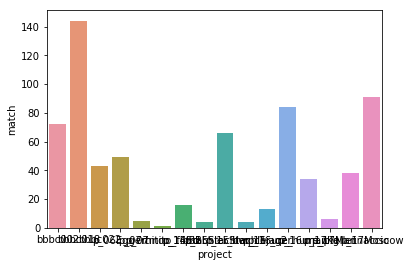

In [5]:
sb.barplot(data=matches.groupby("project").count().reset_index(), x="project", y="match")

In [6]:
if MODE == "TRAINING":
    gt_dir = "/data1/image-segmentation/dsb_eval/raw_annotations/"
elif MODE == "TESTING":
    gt_dir = "/storage/data/DSB2018/phase-2-gt/"

matches["match_width"] = 0
matches["match_height"] = 0
matches["crop_width"] = 0
matches["crop_height"] = 0
matches["SNR"] = 0
matches["CR"] = 0
matches["objects"] = 0
matches["object_size"] = 0

for k,r in matches.iterrows():
    # Handle weird file names
    if MODE == "TESTING":
        r.match = r.match.encode("utf-16", "strict").decode("utf-16")
        s = r.match.encode("utf-16").decode("utf-16").replace("ó","**")
        files = glob.glob(s)
        r.match = files[0]

    # Dimensions of original image
    original = skimage.io.imread(r.match)
    matches.loc[k,"match_width"] = original.shape[0]
    matches.loc[k,"match_height"] = original.shape[1]
    
    # Dimensions of the crop
    crop = skimage.io.imread(r.crop)
    matches.loc[k,"crop_width"] = crop.shape[0]
    matches.loc[k,"crop_height"] = crop.shape[1]
    
    # Load ground truth
    if MODE == "TRAINING":
        masks = skimage.io.imread(gt_dir + r.crop.split("/")[-1].replace(".png", ".tiff"))
    elif MODE == "TESTING":
        masks = skimage.io.imread(gt_dir + r.crop.split("/")[-1])
    if len(crop.shape) > 2:
        crop = np.mean(crop, axis=2)
    matches.loc[k,"objects"] = len(np.unique(masks)) - 1
        
    # SNR
    bg_avg = np.mean( (masks == 0)*crop)
    fg_avg = np.mean( (masks > 0)*crop)
    bg_std = np.std( (masks == 0)*crop)
    matches.loc[k, "SNR"] = np.abs(fg_avg - bg_avg) / bg_std
    
    # Contrast Ratio
    matches.loc[k, "CR"] = fg_avg / bg_avg
    
    # Average object size
    area = 0
    regions = skimage.measure.regionprops(masks)
    for region in regions:
        area += region.area
    matches.loc[k, "object_size"] = area/len(regions)

In [7]:
matches.groupby("project").mean()#["coord_x","coord_y", "match_width", "match_height", "crop_width", "crop_height", "SNR", "CR"].mean()

,Unnamed: 0,coord_x,coord_y,exact,match_width,match_height,crop_width,crop_height,SNR,CR,objects,object_size
project,,,,,,,,,,,,
bbbc002,364.277778,128.000000,128.000000,True,512.0,512.0,256.0,256.0,1.615410,0.340140,40.930556,306.247659
bbbc018,317.458333,128.000000,128.000000,True,512.0,512.0,256.0,256.0,4.812093,0.092777,30.611111,126.136061
bbbc022,326.116279,0.000000,0.000000,True,520.0,696.0,520.0,696.0,1.646974,0.347120,115.813953,623.221590
p_06Eggert,340.938776,254.693878,355.102041,True,1040.0,1392.0,520.0,696.0,2.415012,0.294603,93.183673,1059.452655
p_07mito,404.000000,104.000000,138.800000,True,520.0,694.0,260.0,347.0,1.689949,0.315849,81.600000,142.241824
p_07mito_fibro,430.000000,0.000000,0.000000,True,1040.0,1388.0,1040.0,1388.0,2.948662,0.180198,14.000000,7244.071429
p_14ISBI,301.750000,0.000000,0.000000,True,1024.0,1024.0,1024.0,1024.0,5.981610,0.011893,84.062500,242.483783
p_15Stachler_bw,398.500000,128.000000,160.000000,True,512.0,640.0,256.0,320.0,5.797694,0.382979,26.750000,384.833072
p_15Stachler_c1,313.969697,124.121212,160.000000,True,512.0,640.0,256.0,320.0,2.131907,0.242167,39.439394,723.135541


In [8]:
matches.groupby("project")["exact","objects"].sum()

,exact,objects
project,,
bbbc002,72.0,2947
bbbc018,144.0,4408
bbbc022,43.0,4980
p_06Eggert,49.0,4566
p_07mito,5.0,408
p_07mito_fibro,1.0,14
p_14ISBI,16.0,1345
p_15Stachler_bw,4.0,107
p_15Stachler_c1,66.0,2603


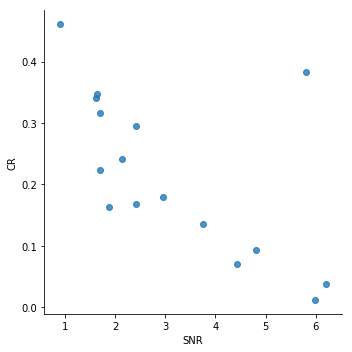

In [9]:
sb.lmplot(data=matches.groupby("project").mean().reset_index(), x="SNR", y="CR", fit_reg=False)

In [10]:
if MODE == "TESTING":
    test_meta = pd.read_csv("/storage/data/DSB2018/metadata/dsb_summary_metadata_stage2testdata_v2.csv")
    test_groups = pd.read_csv("/storage/data/DSB2018/metadata/image_groups_defined_by_beth.csv")

    matches["hash_name"] = matches["crop"].str.split("/", expand=True)[5].str.split(".", expand=True)[0]
    full_meta = pd.merge(test_meta, matches, left_on="hash_name", right_on="hash_name").reset_index()
    full_meta = pd.merge(full_meta, test_groups, left_on="hash_name", right_on="Image")

In [11]:
if MODE == "TESTING":
    x = full_meta.groupby("project_id")["SNR", "CR", "crop_width", "crop_height", "match_width", "match_height", "object_size"].mean()
    x

In [12]:
if MODE == "TESTING":
    y = full_meta.groupby("project_id")["index", "objects"].sum()